# Wildfire Detection - by Selman Tabet @ https://selman.io/

In [21]:
import os
import time


### Environment Setup

In [22]:
print(os.getcwd())

d:\Dissertation\Kaggle Data\wildfire-detection


In [23]:
import socket
print(socket.gethostname())
import os
try: # for CUDA enviroment
    os.system("nvidia-smi")
except:
    pass

Chaos


In [24]:
cuda_visible_devices = os.environ.get('CUDA_VISIBLE_DEVICES')
print(f"CUDA_VISIBLE_DEVICES: {cuda_visible_devices}")

CUDA_VISIBLE_DEVICES: None


### Importing Libraries

In [ ]:
# Data processing libraries
import numpy as np
import pandas as pd
from itertools import combinations
import json

# ML libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S # type: ignore
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow.keras.backend as K
from keras.metrics import Precision, Recall, AUC
from sklearn.model_selection import KFold

# Chart generating libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

# from train_parameters import *
from customnet import *
from custom_metrics import *

### Environment Setup

In [26]:
DATASETS = {
    "The Wildfire Dataset": {
        "train": os.path.join("dataset_1", "train"),
        "test": os.path.join("dataset_1", "test"),
        "val": os.path.join("dataset_1", "val"),
        # "augment": False,
        "source_url": "https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset/"
    },
    "DeepFire": {
        "train": os.path.join("dataset_2", "Training"),
        "test": os.path.join("dataset_2", "Testing"),
        # "augment": False,
        "source_url": "https://www.kaggle.com/datasets/alik05/forest-fire-dataset/"
    },
    "FIRE": {
        "train": "dataset_3",
        # "augment": False,
        "source_url": "https://www.kaggle.com/datasets/phylake1337/fire-dataset/"
    },
}
train_dirs = [DATASETS[dataset].get('train') for dataset in DATASETS]
test_dirs = [DATASETS[dataset].get('test') for dataset in DATASETS]
val_dirs = [DATASETS[dataset].get('val') for dataset in DATASETS]

print(train_dirs)
print(test_dirs)
print(val_dirs)
base_models = [ResNet50V2, InceptionV3, VGG16, VGG19, Xception, MobileNetV2, DenseNet121, EfficientNetV2S, CUSTOMNET]

['dataset_1\\train', 'dataset_2\\Training', 'dataset_3']
['dataset_1\\test', 'dataset_2\\Testing', None]
['dataset_1\\val', None, None]


In [28]:
print(tf.config.get_visible_devices())
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


### Initialize data generators with augmentation

In [29]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Training Hyperparameters

In [30]:
epochs = 80
batch_size = 32
img_height, img_width = 224, 224  # Most Keras Applications have a default input size of 224x224


optimizer_fn = 'adam'
loss_fn = 'binary_crossentropy'


callbacks_list = [
EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
ModelCheckpoint(filepath=os.path.join("tmp", 'temp_model.keras'), monitor='val_loss', save_best_only=True),
ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

checkpoint_path = os.path.join("checkpoint")

metrics_list = ['accuracy', 
                    Precision(name="precision"), 
                    Recall(name="recall"), 
                    AUC(name="auc"), 
                    f1_score
                    ]


### Auxiliary Functions

In [31]:
def samples_from_generators(generators):
    samples = 0
    for generator in generators:
        if generator is not None:
            samples += generator.samples
    return samples

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator, batch_size=32):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def val_split(dataset, samples=None, val_size=0.2):
    # Calculate the number of samples for validation and training
    val_size = int(val_size * samples)
    train_size = samples - val_size
    # Print the sizes of the datasets
    print("Splitted dataset:")
    print(f"Training dataset size: {train_size} samples")
    print(f"Validation dataset size: {val_size} samples")
    val_dataset = dataset.take(val_size)
    train_dataset = dataset.skip(val_size)
    return train_dataset, val_dataset, train_size, val_size

def create_generators(directory, batch_size=32, img_height=224, img_width=224, augment=True, shuffle=True):
    generator = original_datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='rgb',
        shuffle=shuffle
    )
    if augment:
        augmented_generator = augmented_datagen.flow_from_directory(
            directory,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            color_mode='rgb',
            shuffle=shuffle
        )
        return generator, augmented_generator
    return generator, None

def generators_to_dataset(generators, batch_size=32):
    dataset = None
    for generator in generators:
        if generator is not None:
            if dataset is None:
                dataset = create_dataset(generator, batch_size)
            else:
                dataset = dataset.concatenate(create_dataset(generator, batch_size))
    return dataset

def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    dataset_name = os.path.basename(os.path.dirname(directory))
    plt.suptitle(f"Dataset: {dataset_name} - Category: {category}", y=0.8)
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

def show_counts_from_generators(generator, augmented_generator=None):
    print("Number of samples in generator:", generator.samples)
    print("Number of classes:", generator.num_classes)
    print("--------------------")
    class_indices = generator.class_indices
    print("Class indices:", class_indices)
    class_names = list(class_indices.keys())
    print("Class names:", class_names)

    original_class_counts = {class_name: 0 for class_name in class_names}
    augmented_class_counts = {class_name: 0 for class_name in class_names}

    for class_name, class_index in class_indices.items():
        original_class_counts[class_name] = sum(generator.classes == class_index)
        if augmented_generator is not None:
            augmented_class_counts[class_name] = sum(augmented_generator.classes == class_index)

    # Print the results
    print("Dataset Class Counts:")
    for class_name, count in original_class_counts.items():
        print(f"{class_name}: {count}")
    if augmented_generator is not None:
        print("\nAugmented Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count}")
        print("\n")
        print("Combined Dataset Class Counts:")
        for class_name, count in augmented_class_counts.items():
            print(f"{class_name}: {count + original_class_counts[class_name]}")
    print("--------------------")
    
def consolidate_to_train(datasets):
    if len(datasets) == 1:
        return datasets[0]
    elif len(datasets) == 0:
        return None
    else:
        train_dataset = datasets[0]
        for dataset in datasets[1:]:
            train_dataset = train_dataset.concatenate(dataset)
        return train_dataset


### Model Evaluation Generation and Storage Functions

In [32]:
def generate_roc_curve(model, generator, directory, dataset_name):
    # Generate predictions on the validation set
    y_pred_probs = model.predict(generator)

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(generator.classes, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'roc_curve_{model.name}_{dataset_name}.png'))
    plt.close()

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
    
def plot_confusion_matrix(cm, directory, model_name, dataset_name, optimal=False):
    class_names = ['fire', 'nofire']
    # Save the confusion matrix plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    fname = f'confusion_matrix_{model_name}_{dataset_name}_optimal.png' if optimal else f'confusion_matrix_{model_name}_{dataset_name}.png'
    plt.savefig(os.path.join(directory, fname))
    plt.close()

def plot_pr_curve(model, generator, directory, dataset_name):
    generator.reset()
    # Generate predictions on the validation set
    y_pred_probs = model.predict(generator)
    precision, recall, thresholds = precision_recall_curve(generator.classes, y_pred_probs)

    # Plot PR curve
    plt.figure()
    plt.plot(recall, precision, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(directory, f'pr_curve_{model.name}_{dataset_name}.png'))
    plt.close()

# Function to plot and save training history
def plot_history(run_dir, history, model_name, dataset_name):
    # Ensure all arrays in history.history have the same length
    min_length = min(len(values) for values in history.history.values())
    history_dict = {key: values[:min_length] for key, values in history.history.items()}
    history_df = pd.DataFrame(history_dict)
    history_df.to_csv(os.path.join(run_dir, f"history_{model_name}_{dataset_name}.csv"), index=False)
    ## Accuracy and Loss Metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.savefig(os.path.join(run_dir, f"loss_accuracy_{model_name}_{dataset_name}.png"))
    plt.close()

    ## Recall, F1 Score, and Precision Metrics
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    f1 = history.history['f1_score']
    val_f1 = history.history['val_f1_score']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(len(recall))

    plt.figure(figsize=(12, 18))

    # Plot recall
    plt.subplot(3, 1, 1)
    plt.plot(epochs, recall, label='Training Recall')
    plt.plot(epochs, val_recall, label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    # Plot F1 score
    plt.subplot(3, 1, 2)
    plt.plot(epochs, f1, label='Training F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    # Plot precision
    plt.subplot(3, 1, 3)
    plt.plot(epochs, precision, label='Training Precision')
    plt.plot(epochs, val_precision, label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    plt.savefig(os.path.join(run_dir, f"recall_f1_precision_{model_name}_{dataset_name}.png"))
    plt.close()


def plot_test_images(test_generator, directory, dataset_name, model, threshold, optimal=False):
    test_generator.reset()
    while True:
        try:
            test_images, test_labels = next(test_generator)
            predictions = model.predict(test_images)

            fire_indices = np.where(test_labels == 1)[0]
            nofire_indices = np.where(test_labels == 0)[0]

            random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
            random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

            random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
            np.random.shuffle(random_indices)

            # Plot the images with predictions
            plt.figure(figsize=(20, 10))
            for i, idx in enumerate(random_indices):
                plt.subplot(2, 5, i+1)
                plt.imshow(test_images[idx])
                plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= threshold else 'Fire'}")
                plt.axis('off')
            plt.savefig(os.path.join(directory, f"test_images_{model.name}_{dataset_name}_optimal.png" if optimal else f"test_images_{model.name}_{dataset_name}.png"))
            plt.close()
            break

        except ValueError:
            pass



### Evaluation stage ###
def full_eval(model_ds_dir, history, model, dataset_name, test_generator):
    # Plot metrics and save the history
    plot_history(model_ds_dir, history, model.name, dataset_name)
    # Plot the test images with predictions
    plot_test_images(test_generator, model_ds_dir, dataset_name, model, 0.5)

    true_labels = test_generator.classes
    predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()
    # Generate the confusion matrix using the default threshold of 0.5
    cm = confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, model_ds_dir, model.name, dataset_name)

    # Generate the ROC curve
    optimal_threshold = generate_roc_curve(model, test_generator, model_ds_dir, dataset_name)
    
    plot_test_images(test_generator, model_ds_dir, dataset_name, model, optimal_threshold, optimal=True)

    true_labels = test_generator.classes
    predicted_labels_optimal = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()
    # Generate the confusion matrix using the optimal threshold from the ROC curve
    cm_optimal = confusion_matrix(true_labels, predicted_labels_optimal)
    plot_confusion_matrix(cm_optimal, model_ds_dir, model.name, dataset_name, optimal=True)

    # Generate the PR curve
    plot_pr_curve(model, test_generator, model_ds_dir, dataset_name)
    return optimal_threshold

### Generate training and validation datasets

In [33]:
dataset_names = []
train_datasets = [] # [ (dataset_1_train, dataset_2_train), ... ]
train_sizes = [] # [ (dataset_1_train_size, dataset_2_train_size), ... ]
val_datasets = [] # [ (dataset_1_val, dataset_2_val), ... ]
val_sizes = [] # [ (dataset_1_val_size, dataset_2_val_size), ... ]


for d in DATASETS:
    print(f"Processing: {d}")
    train_dir = DATASETS[d]['train']
    augment = DATASETS[d].get('augment', True)
    print("Augmenting" if augment else "Not augmenting", d)
    # Apply original and augmented data generators for training
    print("Creating generators for training")
    train_generator, augmented_train_generator = create_generators(train_dir, augment=augment)
    train_samples = samples_from_generators([train_generator, augmented_train_generator])  
    train_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    
    # Apply original and augmented data generators for validation
    if "val" in DATASETS[d]:
        val_dir = DATASETS[d]['val']
        print("Creating generators for validation")
        val_generator, augmented_val_generator = create_generators(val_dir, augment=augment, shuffle=False)
        val_samples = samples_from_generators([val_generator, augmented_val_generator])
        val_dataset = generators_to_dataset([train_generator, augmented_train_generator], batch_size=batch_size)
    else:
        train_dataset, val_dataset, train_samples, val_samples = val_split(train_dataset, train_samples)
        val_generator, augmented_val_generator = None, None
    
    # Calculate the number of samples for training and validation
    train_sizes.append(train_samples)
    val_sizes.append(val_samples)

    show_counts_from_generators(train_generator, augmented_train_generator)

    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    dataset_names.append(d)
    
# Ensure that the lengths are consistent across the board
assert(len(train_sizes) == len(train_datasets) and len(train_sizes) == len(val_sizes) and len(val_sizes) == len(val_datasets))
# print("Dataset names:", dataset_names)
# print("Train sizes:", train_sizes)
# print("Val sizes:", val_sizes)
# print("Train datasets:", train_datasets)
# print("Val datasets:", val_datasets)

Processing: The Wildfire Dataset
Augmenting The Wildfire Dataset
Creating generators for training
Found 1887 images belonging to 2 classes.
Found 1887 images belonging to 2 classes.
Creating generators for validation
Found 402 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Number of samples in generator: 1887
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Class names: ['fire', 'nofire']
Dataset Class Counts:
fire: 730
nofire: 1157

Augmented Dataset Class Counts:
fire: 730
nofire: 1157


Combined Dataset Class Counts:
fire: 1460
nofire: 2314
--------------------
Processing: DeepFire
Augmenting DeepFire
Creating generators for training
Found 1520 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.
Splitted dataset:
Training dataset size: 2432 samples
Validation dataset size: 608 samples
Number of samples in generator: 1520
Number of classes: 2
--------------------
Class indices: {'fire': 0, 'nofire': 1}
Cla

### Dataset-wise Combination

In [34]:
dataset_combos = [] # [(0,), (1,), (0, 1), ...] where 0, 1 are the indices of the datasets within their respective lists
for r in range(1, len(dataset_names) + 1):
    dataset_combos.extend(combinations(range(len(dataset_names)), r))
print("Combos", dataset_combos)
combined_training_datasets = []
combined_val_datasets = []
combined_dataset_names = []
steps_per_epoch_list = []
validation_steps_list = []

for combo in dataset_combos:
    training_dataset = None
    val_dataset = None
    train_size = None
    val_size = None
    for idx in combo:
        if training_dataset is None:
            training_dataset = train_datasets[idx]
            val_dataset = val_datasets[idx]
            train_size = train_sizes[idx]
            val_size = val_sizes[idx]
        else:
            training_dataset = training_dataset.concatenate(train_datasets[idx])
            val_dataset = val_dataset.concatenate(val_datasets[idx])
            train_size += train_sizes[idx]
            val_size += val_sizes[idx]
    combined_dataset_names.append("_".join([dataset_names[idx] for idx in combo]))
    combined_training_datasets.append(training_dataset)
    combined_val_datasets.append(val_dataset)
    steps_per_epoch_list.append(train_size // batch_size)
    validation_steps_list.append(val_size // batch_size)

Combos [(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]


### Brute Force Consolidation

In [35]:
consolidation_combos = []
consolidated_datasets = train_datasets + val_datasets
consolidated_sizes = train_sizes + val_sizes
# Generate combinations ensuring at least one training dataset
for n in range(1, len(consolidated_datasets) + 1):
    for combo in combinations(range(len(consolidated_datasets)), n):
        if any(idx < len(train_datasets) for idx in combo): # Ensure at least one element from train_datasets
            consolidation_combos.append(combo)

print("Consolidation Combos", consolidation_combos)

# Generate consolidated datasets
consolidated_training_datasets = []
consolidated_steps_per_epoch_list = []
consolidated_ids = []
mapping_dict = {}

for id, combo in enumerate(consolidation_combos):
    train_dataset_names = []
    val_dataset_names = []
    consolidated_training_datasets.append(consolidate_to_train([consolidated_datasets[idx] for idx in combo]))
    consolidated_steps_per_epoch_list.append(sum([consolidated_sizes[idx] for idx in combo]) // batch_size)
    if len(combo) == len(consolidated_datasets):
        mapping_dict["all"] = {"train": "all", "val": "all"}
    else:
        for idx in combo:
            normalized_idx = idx % len(dataset_names) # Normalize the index to the dataset_names list to avoid out of bound access
            if idx < len(dataset_names):
                train_dataset_names.append(dataset_names[normalized_idx])
            else:
                val_dataset_names.append(dataset_names[normalized_idx])
        mapping_dict[id] = {"train": train_dataset_names, "val": val_dataset_names}
    consolidated_ids.append(id) # Keeping this to guarantee the order for training loops
# print("Consolidated Training Datasets", consolidated_training_datasets)
# print("Consolidated Steps Per Epoch", consolidated_steps_per_epoch_list)

print("Mapping Dict", mapping_dict)

# Ensure that the lengths are consistent across the board
assert(len(consolidated_training_datasets) == len(consolidated_steps_per_epoch_list) and len(consolidated_steps_per_epoch_list) == len(consolidated_ids) and len(mapping_dict.keys()) == len(consolidated_ids))

Consolidation Combos [(0,), (1,), (2,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 4), (0, 3, 5), (0, 4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 3, 4), (0, 1, 3, 5), (0, 1, 4, 5), (0, 2, 3, 4), (0, 2, 3, 5), (0, 2, 4, 5), (0, 3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 4, 5), (0, 1, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 3, 4, 5), (0, 1, 2, 3, 4, 5)]
Mapping Dict {0: {'train': ['The Wildfire Dataset'], 'val': []}, 1: {'train': ['DeepFire'], 'val': []}, 2: {'train': ['FIRE'], 'val': []}, 3: {'train': ['The Wildfire Dataset', 'DeepFire'], 'val': []}, 4: {'train': ['The Wildfire Dataset', 'FIRE'], 'val': []}, 5: {'train': ['The Wildfire Dataset'], 'val': ['The Wildfire D

### Generate the test dataset

In [36]:

test_dir = "test_combined"
test_generator, augmented_test_generator = create_generators(test_dir, augment=False, shuffle=False) # No augmentation for testing
test_dataset = create_dataset(test_generator)

print("Class indices:", test_generator.class_indices)
print("\n")
print("Test Dataset Class Counts:")
for class_name, class_index in test_generator.class_indices.items():
    print(f"{class_name}: {sum(test_generator.classes == class_index)}")
print("\n")

Found 858 images belonging to 2 classes.
Class indices: {'fire': 0, 'nofire': 1}


Test Dataset Class Counts:
fire: 371
nofire: 487




### Data Visualization

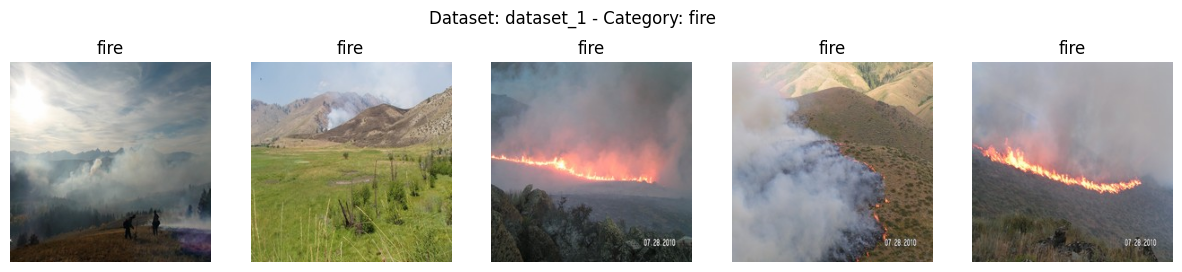

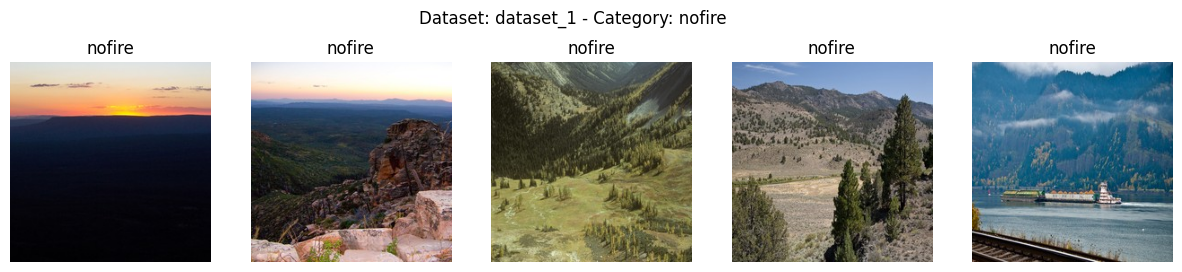

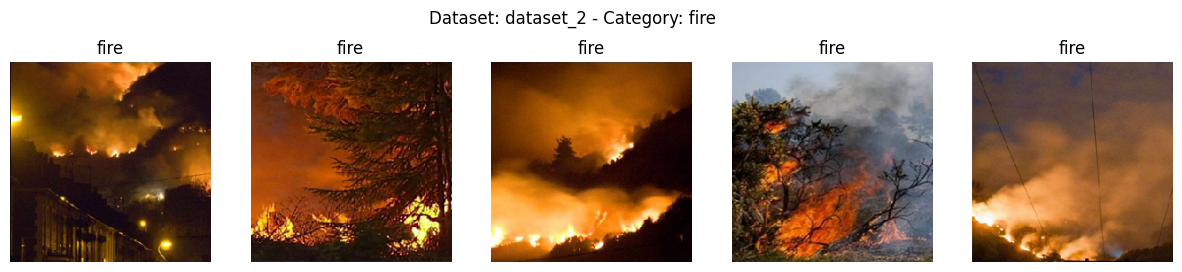

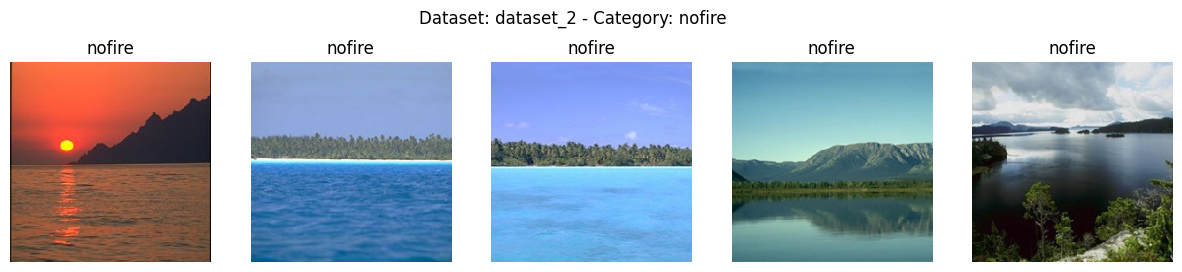

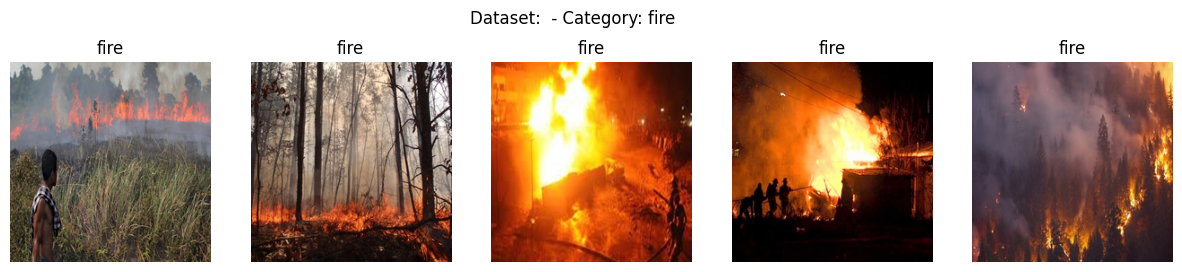

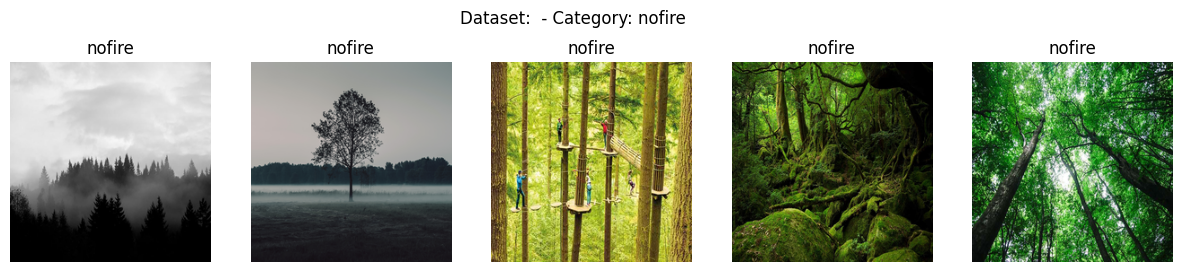

In [37]:
for train_dir in train_dirs:
    # Plotting 5 fire and 5 nofire images
    plot_images(train_dir, 'fire', 5)
    plot_images(train_dir, 'nofire', 5)


### Model Preparation

In [38]:

def generate_model(bm):
    if bm == CUSTOMNET:
        model = bm
        model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=metrics_list)
        model.save_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))    
        return model
    
    base_model = bm(
        include_top=False,
        weights='imagenet',
        input_shape=(img_height, img_width, 3)
    )
    base_model.trainable = False

    # Create the model
    inputs = Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name=bm.__name__)
    model.compile(optimizer=optimizer_fn, loss=loss_fn, metrics=metrics_list)
    model.save_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))    
    return model

### Training and evaluating the models

In [39]:
training_results = {}
run_number = len([d for d in os.listdir("runs") if os.path.isdir(os.path.join("runs", d)) and d.startswith('run_')]) + 1
run_dir = os.path.join("runs", f"run_{run_number}")
os.makedirs(run_dir, exist_ok=True)

with open(os.path.join(run_dir, 'brute_force_mapping_dict.json'), 'w') as f:
    json.dump(mapping_dict, f, indent=4)

In [40]:

results_file = os.path.join(run_dir, 'training_results.json')

for base_model in base_models:
    model = generate_model(base_model) # To display the model summary
    model.summary()
    training_results[model.name] = {}
    plot_model(model, show_shapes=True, show_layer_names=True, to_file=os.path.join("architectures", f"{model.name}_architecture.png"))
    for dataset_id, train_dataset, val_dataset, steps_per_epoch, validation_steps in zip(combined_dataset_names, combined_training_datasets, combined_val_datasets, steps_per_epoch_list, validation_steps_list):
        model.load_weights(os.path.join(checkpoint_path, f"{model.name}_initial.weights.h5"))
        print(f"Training model: {model.name} on dataset: {dataset_id}")
        
        # Record the start time
        start_time = time.time()

        # Initial training of the model
        history = model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks_list
        )

        # Record the end time
        end_time = time.time()
        # Calculate the training time
        training_time = end_time - start_time
        print(f"Training time: {training_time:.2f} seconds")

        model_ds_dir = os.path.join(run_dir, model.name, dataset_id)
        os.makedirs(model_ds_dir, exist_ok=True)
        # Save the model
        model.save(os.path.join(model_ds_dir, f"{model.name}_{dataset_id}.keras"))

        ### Evaluation stage ###
        optimal_threshold = full_eval(model_ds_dir, history, model, dataset_id, test_generator)
        
        training_results[model.name][dataset_id] = {
            'history': history.history,
            'training_time': training_time,
            'optimal_threshold': float(optimal_threshold),
            'train_dataset_size': steps_per_epoch * batch_size,
            'val_dataset_size': validation_steps * batch_size,
            "evaluation": model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size)
        }
        
        print(training_results)

        # Save the training results to a file after each iteration
        with open(results_file, 'w') as f:
            json.dump(training_results, f, indent=4)
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics_list) # Reset the model for the next iteration

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

Training model: ResNet50V2 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 94s 763ms/step - accuracy: 0.7499 - auc: 0.8224 - f1_score: 0.7729 - loss: 0.6212 - precision: 0.8289 - recall: 0.7356 - val_accuracy: 0.9013 - val_auc: 0.9689 - val_f1_score: 0.9197 - val_loss: 0.2508 - val_precision: 0.9309 - val_recall: 0.9105 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 74s 637ms/step - accuracy: 0.8577 - auc: 0.9301 - f1_score: 0.8820 - loss: 0.3476 - precision: 0.8814 - recall: 0.8864 - val_accuracy: 0.9312 - val_auc: 0.9840 - val_f1_score: 0.9456 - val_loss: 0.1887 - val_precision: 0.9288 - val_recall: 0.9669 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 80s 689ms/step - accuracy: 0.8856 - auc: 0.9478 - f1_score: 0.9055 - loss: 0.2897 - precision: 0.9019 - recall: 0.9112 - val_accuracy: 0.9650 - val_auc: 0.9945 - val_f1_score: 0.9707 - val_loss: 0.1359 - val_precision: 0.9663 - val_recall: 0.9779 - learning_rate: 0.0010
Epoch 4

d:\Dissertation\Kaggle Data\wildfire-detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 520ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - accuracy: 0.8275 - auc: 0.5329 - f1_score: 0.2073 - loss: 0.5159 - precision: 0.3992 - recall: 0.4702
{'ResNet50V2': {'The Wildfire Dataset': {'history': {'accuracy': [0.7967414259910583, 0.8717948794364929, 0.8883547186851501, 0.8926281929016113, 0.9051816463470459, 0.9212072491645813, 0.9305555820465088, 0.9332264661

Model: "InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336,801 (85.21 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 21,807,392 (83.19 MB)

Training model: InceptionV3 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 65s 507ms/step - accuracy: 0.7875 - auc: 0.8806 - f1_score: 0.8206 - loss: 0.5427 - precision: 0.8432 - recall: 0.8357 - val_accuracy: 0.9087 - val_auc: 0.9723 - val_f1_score: 0.9192 - val_loss: 0.2436 - val_precision: 0.9416 - val_recall: 0.9044 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 53s 449ms/step - accuracy: 0.8741 - auc: 0.9407 - f1_score: 0.8989 - loss: 0.2996 - precision: 0.8959 - recall: 0.9037 - val_accuracy: 0.9438 - val_auc: 0.9870 - val_f1_score: 0.9491 - val_loss: 0.1680 - val_precision: 0.9387 - val_recall: 0.9652 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 420ms/step - accuracy: 0.8908 - auc: 0.9536 - f1_score: 0.9119 - loss: 0.2686 - precision: 0.8954 - recall: 0.9308 - val_accuracy: 0.9700 - val_auc: 0.9965 - val_f1_score: 0.9752 - val_loss: 0.1138 - val_precision: 0.9658 - val_recall: 0.9856 - learning_rate: 0.0010
Epoch 

Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,345 (56.65 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Training model: VGG16 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.6569 - auc: 0.8178 - f1_score: 0.6916 - loss: 0.7517 - precision: 0.7973 - recall: 0.7556 - val_accuracy: 0.7150 - val_auc: 0.8873 - val_f1_score: 0.8040 - val_loss: 0.5594 - val_precision: 0.6790 - val_recall: 0.9958 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7679 - auc: 0.8385 - f1_score: 0.8104 - loss: 0.5022 - precision: 0.8139 - recall: 0.8122 - val_accuracy: 0.8350 - val_auc: 0.9173 - val_f1_score: 0.8702 - val_loss: 0.4627 - val_precision: 0.8480 - val_recall: 0.8986 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8013 - auc: 0.8743 - f1_score: 0.8391 - loss: 0.4364 - precision: 0.8329 - recall: 0.8495 - val_accuracy: 0.8587 - val_auc: 0.9397 - val_f1_score: 0.8885 - val_loss: 0.3881 - val_precision: 0.8731 - val_recall: 0.9062 - learning_rate: 0.0010
Epoch 4/80
117/117

Model: "VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_107         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,159,041 (76.90 MB)

 Trainable params: 133,121 (520.00 KB)

 Non-trainable params: 20,025,920 (76.39 MB)

Training model: VGG19 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.6065 - auc: 0.7119 - f1_score: 0.6601 - loss: 0.8103 - precision: 0.7082 - recall: 0.7374 - val_accuracy: 0.6612 - val_auc: 0.8606 - val_f1_score: 0.7664 - val_loss: 0.5886 - val_precision: 0.6314 - val_recall: 0.9870 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.7344 - auc: 0.8035 - f1_score: 0.7828 - loss: 0.5520 - precision: 0.7883 - recall: 0.7820 - val_accuracy: 0.8325 - val_auc: 0.9092 - val_f1_score: 0.8693 - val_loss: 0.4944 - val_precision: 0.8467 - val_recall: 0.8970 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.7624 - auc: 0.8394 - f1_score: 0.8062 - loss: 0.4955 - precision: 0.8128 - recall: 0.8010 - val_accuracy: 0.8375 - val_auc: 0.9126 - val_f1_score: 0.8636 - val_loss: 0.4294 - val_precision: 0.8383 - val_recall: 0.8985 - learning_rate: 0.0010
Epoch 4/80
117/117

Model: "Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,395,497 (81.62 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 20,866,088 (79.60 MB)

Training model: Xception on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 106s 874ms/step - accuracy: 0.7567 - auc: 0.8169 - f1_score: 0.7958 - loss: 0.6190 - precision: 0.8010 - recall: 0.7747 - val_accuracy: 0.8500 - val_auc: 0.9537 - val_f1_score: 0.8874 - val_loss: 0.3452 - val_precision: 0.8112 - val_recall: 0.9815 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 113s 970ms/step - accuracy: 0.8588 - auc: 0.9195 - f1_score: 0.8882 - loss: 0.3580 - precision: 0.8751 - recall: 0.9018 - val_accuracy: 0.8925 - val_auc: 0.9775 - val_f1_score: 0.9163 - val_loss: 0.2521 - val_precision: 0.8658 - val_recall: 0.9778 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 98s 840ms/step - accuracy: 0.8695 - auc: 0.9443 - f1_score: 0.8939 - loss: 0.2966 - precision: 0.9036 - recall: 0.8861 - val_accuracy: 0.9025 - val_auc: 0.9811 - val_f1_score: 0.9252 - val_loss: 0.2159 - val_precision: 0.8770 - val_recall: 0.9820 - learning_rate: 0.0010
Epoch 4

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,321 (9.89 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

Training model: MobileNetV2 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 30s 221ms/step - accuracy: 0.7529 - auc: 0.8662 - f1_score: 0.7855 - loss: 0.5764 - precision: 0.8149 - recall: 0.8323 - val_accuracy: 0.9038 - val_auc: 0.9645 - val_f1_score: 0.9181 - val_loss: 0.2578 - val_precision: 0.9168 - val_recall: 0.9226 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.8668 - auc: 0.9322 - f1_score: 0.8906 - loss: 0.3380 - precision: 0.8889 - recall: 0.8947 - val_accuracy: 0.9400 - val_auc: 0.9849 - val_f1_score: 0.9507 - val_loss: 0.1764 - val_precision: 0.9601 - val_recall: 0.9450 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 25s 218ms/step - accuracy: 0.8867 - auc: 0.9549 - f1_score: 0.9057 - loss: 0.2703 - precision: 0.9058 - recall: 0.9068 - val_accuracy: 0.9488 - val_auc: 0.9910 - val_f1_score: 0.9588 - val_loss: 0.1476 - val_precision: 0.9547 - val_recall: 0.9642 - learning_rate: 0.0010
Epoch 

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,281 (27.87 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

Training model: DenseNet121 on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 105s 823ms/step - accuracy: 0.7411 - auc: 0.8801 - f1_score: 0.7719 - loss: 0.5521 - precision: 0.8295 - recall: 0.8151 - val_accuracy: 0.8687 - val_auc: 0.9617 - val_f1_score: 0.8974 - val_loss: 0.2878 - val_precision: 0.8418 - val_recall: 0.9626 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 98s 839ms/step - accuracy: 0.8603 - auc: 0.9323 - f1_score: 0.8874 - loss: 0.3311 - precision: 0.8868 - recall: 0.8903 - val_accuracy: 0.9100 - val_auc: 0.9839 - val_f1_score: 0.9276 - val_loss: 0.2034 - val_precision: 0.8959 - val_recall: 0.9679 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 100s 852ms/step - accuracy: 0.8839 - auc: 0.9502 - f1_score: 0.9043 - loss: 0.2807 - precision: 0.8928 - recall: 0.9172 - val_accuracy: 0.9200 - val_auc: 0.9807 - val_f1_score: 0.9339 - val_loss: 0.1987 - val_precision: 0.9105 - val_recall: 0.9630 - learning_rate: 0.0010
Epoc

Model: "EfficientNetV2S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,665,697 (78.83 MB)

 Trainable params: 331,265 (1.26 MB)

 Non-trainable params: 20,334,432 (77.57 MB)

Training model: EfficientNetV2S on dataset: The Wildfire Dataset
Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 120s 902ms/step - accuracy: 0.5613 - auc: 0.7316 - f1_score: 0.6102 - loss: 0.9833 - precision: 0.7342 - recall: 0.7225 - val_accuracy: 0.5975 - val_auc: 0.7042 - val_f1_score: 0.7446 - val_loss: 0.6994 - val_precision: 0.5975 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 110s 942ms/step - accuracy: 0.6164 - auc: 0.6064 - f1_score: 0.7003 - loss: 0.7710 - precision: 0.6704 - recall: 0.7409 - val_accuracy: 0.6187 - val_auc: 0.6967 - val_f1_score: 0.7611 - val_loss: 0.6404 - val_precision: 0.6187 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 97s 835ms/step - accuracy: 0.6238 - auc: 0.6279 - f1_score: 0.6998 - loss: 0.7184 - precision: 0.6766 - recall: 0.7367 - val_accuracy: 0.5875 - val_auc: 0.7635 - val_f1_score: 0.7304 - val_loss: 0.6319 - val_precision: 0.5847 - val_recall: 0.9914 - learning_rate: 0.0010


Model: "WildfireNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,819,073 (98.49 MB)

 Trainable params: 25,817,857 (98.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'checkpoint\WildfireNet_initial.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print("Brute force loop completed!")
print(f"All models and evaluations are available at: {run_dir}")

In [ ]:
from pprint import pprint
pprint(history.history)
print(model.evaluate(test_dataset, return_dict=True, steps=test_generator.samples // batch_size))